# Warning

This tutorial is a work in progress, it does not cover all the functionalities yet. However, it will give you a good overview how you can generate tumor segmentations with BraTS Toolkit.


# Glioma segmentation with BraTS Toolkit

In this Notebook, we will demonstrate how to preprocess brain MR images with the [BrainLes preprocessing package](https://github.com/BrainLesion/preprocessing/tree/main/brainles_preprocessing). Following we will generate glioma segmentations with multiple algorithms from [BraTS Toolkit](https://github.com/neuronflow/BraTS-Toolkit) and fuse them together.

![Pipeline Overview](Pipeline_overview.jpg)

---   
### Agenda: 

1. Getting started (requirements, installations)
  
         
2. **Import** of raw data (cMRI)
    
        
3. **Preprocessing via BrainLes preprocessig package** instead of vanilla preprocessing pipeline from BraTS Toolkit. BraTS challenge algorithms expect preprocessed files (co-registered, skullstripped in SRI-24 space)
     
          
4. **Segmentation with BraTS Toolkit** 
      
            
5. **Fusion** of generated segementations 



## 1. Getting Started

### Requirements

This tutorial requires:

- Python 3.10+ environment
- Docker (we recommended the most recent version)
<!-- TODO specify version -->

optional (but recommended):

- CUDA drivers
- a GPU that is supported (each algorithms supports different set of GPUs)
<!-- TODO specify -->

Run the subsequent cell to check CUDA availability, your python and docker version.  

In [1]:
# Your python version (in this notebook) is:
import sys
print(f"Python {sys.version}")

# Check if CUDA is available
import torch
if torch.cuda.is_available():
    # Get the number of available CUDA devices
    num_cuda_devices = torch.cuda.device_count()
    print(f"CUDA is available with {num_cuda_devices} device(s): {torch.cuda.get_device_name()}")
else:
    print("CUDA is not available on this system.")

    
# Print docker version
import subprocess
try:
    result = subprocess.run(['docker', '--version'])
except FileNotFoundError as e:
    print("'docker' seems not to be installed. For installation guide see https://docs.docker.com/get-docker/")
                            


Python 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
CUDA is available with 1 device(s): NVIDIA GeForce GTX 1660 SUPER
Docker version 24.0.5, build 24.0.5-0ubuntu1~22.04.1


## Installation of dependencies


In [2]:
%pip install -U brainles_preprocessing brats_toolkit auxiliary > /dev/null
%pip install -U matplotlib > /dev/null

%load_ext autoreload
%autoreload 2

#package installation may take a while 

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
brainles-aurora 0.1.3 requires auxiliary<0.0.41,>=0.0.40, but you have auxiliary 0.0.41 which is incompatible.
brainles-aurora 0.1.3 requires nibabel>=4.0.2, but you have nibabel 3.2.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Setup Colab environment (optional)

If you installed the packages and requirements on your own machine, you can skip this section and start from the import section. Otherwise you can follow and execute the tutorial on your browser. In order to start working on the notebook, click on the following button, this will open this page in the Colab environment and you will be able to execute the code on your own (*Google account required*).

<a target="_blank" href="https://colab.research.google.com/github/BrainLesion/tutorials/blob/main/BraTS-Toolkit/glioma_segmentation_with_BraTS_Toolkit.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

(EVA VERSION):
<a target="_blank" href="https://colab.research.google.com/github/evamariie/tutorials/blob/main/BraTS-Toolkit/glioma_segmentation_with_BraTS_Toolkit.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt=""/>
</a>

Now that you are visualizing the notebook in Colab, run the next cell to install the packages we will use. There are few things you should follow in order to properly set the notebook up:

- Warning: This notebook was not authored by Google. Click on 'Run anyway'.
- When the installation commands are done, there might be "Restart runtime" button at the end of the output. Please, click it.


If you run the next cell in a Google Colab environment, it will **clone the 'tutorials' repository** in your google drive. This will create a **new folder** called "tutorials" in **your Google Drive**.
All generated file will be created/uploaded to your Google Drive respectively.

After the first execution of the next cell, you might receive some warnings and notifications, please follow these instructions:
   - 'Permit this notebook to access your Google Drive files?' Click on 'Yes', and select your account.
   - Google Drive for desktop wants to access your Google Account. Click on 'Allow'.

This will create the "tutorials" folder. You can navigate it through the lefthand panel in Colab. You might also have received an email that informs you about the access on your Google Drive.

In [3]:
import sys

#Check if we are in google colab currently
try:
    import google.colab
    colabFlag = True
except ImportError as r:
    colabFlag = False

#Execute certain steps only if we are in a colab environment
if colabFlag:
    # Create a folder in your Google Drive
    from google.colab import drive
    drive.mount('/content/drive')
    #clone repository and set path
    !git clone https://github.com/BrainLesion/tutorials.git /content/drive/MyDrive/tutorials
    BASE_PATH = "/content/drive/MyDrive/tutorials/BraTS-Toolkit/"
    sys.path.insert(0, BASE_PATH)
    
else: # normal jupyter notebook environment
    BASE_PATH = "./" #current working directory would be BraTs-Toolkit anyways if you are not in colab
    

## 2. Import raw input data

Raw imput data require
- exam with skull and 4 sequences (T1, T1c, T2, T2-FLAIR), only one file each (in total 4 files) 
    - file names must end with "*t1.nii.gz", "*t1c.nii.gz", "*t2.nii.gz" and "*fla.nii.gz"
    - [Nifti ".nii.gz"](https://brainder.org/2012/09/23/the-nifti-file-format/) file type 
- each exam (4 files) needs to be places in an individual folder within the data folder 
```<this repository>/BraTS-Toolkit/data/```. 

The structure is shown using two example exams:
```
BraTS-Toolkit
├── data
│   ├── TCGA-DU-7294
│   │   ├── *_t1c.nii.gz
│   │   ├── *_t1.nii.gz
│   │   ├── *_t2.nii.gz
│   │   ├── *_fla.nii.gz
│   ├── OtherEXampleFromTCIA
│   │   ├── *_t1c.nii.gz
│   │   ├── *_t1.nii.gz
│   │   ├── *_t2.nii.gz
│   │   ├── *_fla.nii.gz
```


### Example Data
Two examples of cMRI from TCIA/TCGA with T1, T1c, T2, T2-FLAIR with skull are provided.

Run the subsequent cell for visualizing one example sample.
 

/home/eva/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


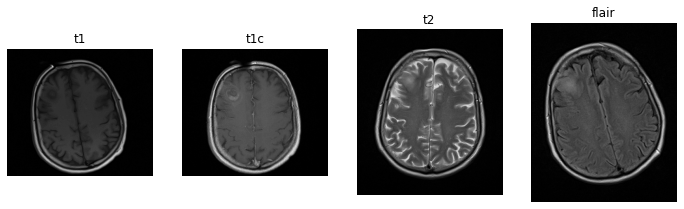

In [4]:
from utils import visualize_data, visualize_data2
from pathlib import Path

#paths to example files   
t1c_path = Path(f"{BASE_PATH}/data/OtherEXampleFromTCIA/MRHR_T1_AX_POST_GAD_OtherEXampleTCIA_TCGA-FG-6692_Si_TCGA-FG-6692_MRHR_T1_AX_POST_GAD_SE_13_se2d1r_t1c.nii.gz")
t1_path = Path(f"{BASE_PATH}/data/OtherEXampleFromTCIA/T1_AX_OtherEXampleTCIA_TCGA-FG-6692_Si_TCGA-FG-6692_T1_AX_SE_10_se2d1_t1.nii.gz")
t2_path = Path(f"{BASE_PATH}/data/OtherEXampleFromTCIA/MRHR_T2_AX_OtherEXampleTCIA_TCGA-FG-6692_Si_TCGA-FG-6692_MRHR_T2_AX_SE_2_tse2d1_11_t2.nii.gz")
flair_path = Path(f"{BASE_PATH}/data/OtherEXampleFromTCIA/MRHR_FLAIR_AX_OtherEXampleTCIA_TCGA-FG-6692_Si_TCGA-FG-6692_MRHR_FLAIR_AX_SE_IR_5_tir2d1_21_fla.nii.gz")

#visualize example images
visualize_data2(t1c_path, t1_path, t2_path, flair_path, height_p=0.75)


## 3. Preprocessing

BraTS challenge algorithms expect co-registered, skullstripped files in SRI-24 space, to achieve this preprocessing is required.
Instead of using the vanilla preprocessing pipeline from BraTS Toolkit, we recommend using the new [BrainLes preprocessing package](https://github.com/BrainLesion/preprocessing/tree/main/brainles_preprocessing).


#### First, we define a function that processes an exam.

In [5]:
from auxiliary.normalization.percentile_normalizer import PercentileNormalizer
from auxiliary.turbopath import turbopath
from tqdm import tqdm

from brainles_preprocessing.brain_extraction import HDBetExtractor
from brainles_preprocessing.modality import Modality
from brainles_preprocessing.preprocessor import Preprocessor
from brainles_preprocessing.registration import NiftyRegRegistrator


def preprocess_exam_in_brats_style(inputDir: str) -> None:
    """
    Perform BRATS (Brain Tumor Segmentation) style preprocessing on MRI exam data.

    Args:
        inputDir (str): Path to the directory containing raw MRI files for an exam.
        File names must end with "t1.nii.gz", "t1c.nii.gz" "t2.nii.gz" or "fla.nii.gz" to be found!

    Raises:
        Exception: If any error occurs during the preprocessing.

    Example:
        brat_style_preprocess_exam("/path/to/exam_directory")

    This function preprocesses MRI exam data following the BRATS style, which includes the following steps:
    1. Normalization using a percentile normalizer.
    2. Registration and correction using NiftyReg.
    3. Brain extraction using HDBet.

    The processed data is saved in a structured directory within the input directory.

    Args:
        inputDir (str): Path to the directory containing raw MRI files for an exam.

    Returns:
        None
    """
    inputDir = turbopath(inputDir)
    print("*** start ***")
    brainles_dir = turbopath(inputDir) + "/" + inputDir.name + "_brainles"
    norm_bet_dir = brainles_dir / "normalized_bet"
    raw_bet_dir = brainles_dir / "raw_bet"

    t1_file = inputDir.files("*t1.nii.gz")
    t1c_file = inputDir.files("*t1c.nii.gz")
    t2_file = inputDir.files("*t2.nii.gz")
    flair_file = inputDir.files("*fla.nii.gz")

    # we check that we have only one file of each type
    if len(t1_file) == len(t1c_file) == len(t2_file) == len(flair_file) == 1:
        t1File = t1_file[0]
        t1cFile = t1c_file[0]
        t2File = t2_file[0]
        flaFile = flair_file[0]

        # normalizer
        percentile_normalizer = PercentileNormalizer(
            lower_percentile=0.1,
            upper_percentile=99.9,
            lower_limit=0,
            upper_limit=1,
        )
        # define modalities
        center = Modality(
            modality_name="t1c",
            input_path=t1cFile,
            raw_bet_output_path=raw_bet_dir / inputDir.name + "_t1c_bet.nii.gz",
            atlas_correction=True, 
            normalizer=percentile_normalizer,
        )
        moving_modalities = [
            Modality(
                modality_name="t1",
                input_path=t1File,
                raw_bet_output_path=raw_bet_dir / inputDir.name + "_t1_bet.nii.gz",
                atlas_correction=True,
                normalizer=percentile_normalizer,
            ),
            Modality(
                modality_name="t2",
                input_path=t2File,
                raw_bet_output_path=raw_bet_dir / inputDir.name + "_t2_bet.nii.gz",
                atlas_correction=True,
                normalizer=percentile_normalizer,
            ),
            Modality(
                modality_name="flair",
                input_path=flaFile,
                raw_bet_output_path=raw_bet_dir / inputDir.name + "_fla_bet.nii.gz",
                atlas_correction=True,
                normalizer=percentile_normalizer,
            ),
        ]
        preprocessor = Preprocessor(
            center_modality=center,
            moving_modalities=moving_modalities,
            registrator=NiftyRegRegistrator(),
            brain_extractor=HDBetExtractor(),
            temp_folder="temporary_directory",
            limit_cuda_visible_devices="0",
        )
        preprocessor.run()

/home/eva/.local/lib/python3.10/site-packages/brainles_preprocessing/registration/__init__.py:6: UserWarning: ANTS package not found. If you want to use it, please install it using 'pip install brainles_preprocessing[ants]'
  warnings.warn(


#### Now we loop through the exams to preprocess the data:
(This may take more than 10 minutes)

In [6]:
EXAMPLE_DATA_DIR = turbopath(f"{BASE_PATH}/data")

exams = EXAMPLE_DATA_DIR.dirs()

for exam in tqdm(exams):
    print("processing:", exam)
    preprocess_exam_in_brats_style(exam)

  0%|                                                     | 0/2 [00:00<?, ?it/s]

processing: /home/eva/Schreibtisch/GitHub_repos/tutorials/BraTS-Toolkit/data/TCGA-DU-7294
*** start ***
File: /home/eva/Schreibtisch/GitHub_repos/tutorials/BraTS-Toolkit/temporary_directory/atlas-space/atlas__t1c.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0


  0%|                                                     | 0/2 [05:43<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 526.00 MiB. GPU 0 has a total capacity of 5.79 GiB of which 333.94 MiB is free. Process 19627 has 11.84 MiB memory in use. Process 28639 has 13.84 MiB memory in use. Process 81919 has 2.79 GiB memory in use. Including non-PyTorch memory, this process has 1.77 GiB memory in use. Of the allocated memory 1.45 GiB is allocated by PyTorch, and 240.80 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

#### Storage of preprocessed data 

The preprocessed data is saved in a newly created folder "raw_bet": 

```data/<datasetName>/<datasetName>_brainles/raw_bet```

Run the subsequent cell for visualizing one preprocessed example sample.

In [ ]:
from utils import visualize_data2
from pathlib import Path

#paths to example files   
t1c_path = Path(f"{BASE_PATH}/data/OtherEXampleFromTCIA/OtherEXampleFromTCIA_brainles/raw_bet/OtherEXampleFromTCIA_t1c_bet.nii.gz")
t1_path = Path(f"{BASE_PATH}/data/OtherEXampleFromTCIA/OtherEXampleFromTCIA_brainles/raw_bet/OtherEXampleFromTCIA_t1_bet.nii.gz")
t2_path = Path(f"{BASE_PATH}/data/OtherEXampleFromTCIA/OtherEXampleFromTCIA_brainles/raw_bet/OtherEXampleFromTCIA_t2_bet.nii.gz")
flair_path = Path(f"{BASE_PATH}/data/OtherEXampleFromTCIA/OtherEXampleFromTCIA_brainles/raw_bet/OtherEXampleFromTCIA_fla_bet.nii.gz")
#visualize example images
visualize_data2(t1c_path, t1_path, t2_path, flair_path, height_p= 0.60 )

---

## 4. Segmentation with BraTS Toolkit

Now that we have preprocessed the data, we can start segmenting the data with BraTS Toolkit.

#### Therefore, we again define a function to segment our files:

In [ ]:
from brats_toolkit.segmentor import Segmentor
import os
from auxiliary.turbopath import turbopath
from tqdm import tqdm


def segment_exam(
    t1_file: str,
    t1c_file: str,
    t2_file: str,
    fla_file: str,
    segmentation_file: str,
    cid: str,
    cuda_device="0",
) -> None:
    """
    segment_exam - Segments MRI images using a specified algorithm from the BRATS toolkit.

    Parameters:
        t1_file (str): Path to the T1-weighted MRI image file.
        t1c_file (str): Path to the T1-weighted contrast-enhanced MRI image file.
        t2_file (str): Path to the T2-weighted MRI image file.
        fla_file (str): Path to the Fluid-attenuated inversion recovery (FLAIR) MRI image file.
        segmentation_file (str): Path to the output file where the segmented image will be saved.
        cid (str): Algorithm identifier for segmentation.
        cuda_device (str, optional): CUDA device ID for GPU acceleration. Default is "0".

    Returns:
        None

    Example:
        segment_exam(
            t1_file='/path/to/t1.nii.gz',
            t1c_file='/path/to/t1c.nii.gz',
            t2_file='/path/to/t2.nii.gz',
            fla_file='/path/to/fla.nii.gz',
            segmentation_file='/path/to/segmentation_result.nii.gz',
            cid="mic-dkfz"
        )

    This function segments MRI images using the specified algorithm from the BRATS toolkit. It accepts paths to T1-weighted,
    T1-weighted contrast-enhanced, T2-weighted, and FLAIR MRI images, and performs segmentation using the specified algorithm.
    The segmented image is saved in the specified output file.

    Note:
        - The function uses the BRATS toolkit's Segmentor for segmentation.
        - The 'cid' parameter specifies the algorithm to use.
        - Segmentation results are saved with a file name corresponding to the algorithm identifier (cid).
        - Errors during segmentation are caught, and an error message is printed.
    """

    # instantiate
    seg = Segmentor(
        verbose=True,
        gpu=cuda_device,
    )

    # algorithms we want to select for segmentation

    # execute it
    if not os.path.exists(segmentation_file):
        seg.segment(
            t1=t1_file,
            t2=t2_file,
            t1c=t1c_file,
            fla=fla_file,
            cid=cid,
            outputPath=segmentation_file,
        )
    else:
        print(segmentation_file, "already exists")

#### Now we again loop through our exams:


In [ ]:
EXAMPLE_DATA_DIR = turbopath(f"{BASE_PATH}/data")

exams = EXAMPLE_DATA_DIR.dirs()
# we use these five algorithms to segment the images
# 2019 algorithms
# cids = ["mic-dkfz", "scan", "xfeng", "lfb_rwth", "zyx_2019", "scan_2019"]

# 2020 algorithms
cids = ["isen-20", "hnfnetv1-20", "yixinmpl-20", "sanet0-20", "scan-20"]


for exam in tqdm(exams, desc="Exams"):
    for cid in tqdm(cids, desc="Algorithms", leave=False):
        print("segmenting:", exam, "with algorithm:", cid)
        brainles_folder = exam / exam.name + "_brainles"
        preprocessed_folder = brainles_folder / "raw_bet"
        segmentation_folder = brainles_folder / "segmentation"

        segmentation_file = segmentation_folder / cid + ".nii.gz"

        segment_exam(
            t1_file=preprocessed_folder / exam.name + "_t1_bet.nii.gz",
            t1c_file=preprocessed_folder / exam.name + "_t1c_bet.nii.gz",
            t2_file=preprocessed_folder / exam.name + "_t2_bet.nii.gz",
            fla_file=preprocessed_folder / exam.name + "_fla_bet.nii.gz",
            segmentation_file=segmentation_file,
            cid=cid,
            cuda_device="0",
        ),

#### The segementations are stored in folder "segmentation" 
```data/<datasetName>/<datasetName>_brainles```

Segmentation results are saved with a file name corresponding to the algorithm identifier (cid).

Algorithms used in this notebook:
- yixinmpl-20
- isen-20
- hnfnetv1-20
- scan-20
- sanet0-20
 
For more details on the algorithms (docker images) see the [publication table of the BraTS toolkit](https://github.com/neuronflow/BraTS-Toolkit/tree/main?tab=readme-ov-file#citation)

---

## 5. Fusion

#### Now we can fuse the generated segmentations together. Therefore we again define a function to process our exams:


In [ ]:
from brats_toolkit.fusionator import Fusionator


def fuse_segmentation_exam(
    segmentation_folder: str,
    fusion_folder: str,
):
    """
    Fuse multiple segmentations using different methods and save the results.

    Parameters:
    - segmentation_folder (str): Path to the folder containing segmentation files in NIfTI format (*.nii.gz).
    - fusion_folder (str): Path to the folder where fused segmentation results will be saved.

    Returns:
    None

    Example:
    ```python
    fuse_segmentation_exam("/path/to/segmentations", "/path/to/fusion_results")
    ```

    This function uses the Fusionator class from the brats_toolkit to fuse segmentations using two different methods:
    1. Multimodal Average (MAV) method.
    2. Simple fusion method.

    The fused segmentations are saved in the specified `fusion_folder` with file names "mav.nii.gz" and "simple.nii.gz".

    Note:
    - The Fusionator class must be available and correctly imported from the brats_toolkit.
    - The segmentation files in the `segmentation_folder` should be in NIfTI format (*.nii.gz).

    Args:
    - segmentation_folder (str): Path to the folder containing segmentation files in NIfTI format (*.nii.gz).
    - fusion_folder (str): Path to the folder where fused segmentation results will be saved.
    """
    # instantiate
    fus = Fusionator(verbose=True)

    # segmentation file paths
    segmentations = segmentation_folder.files("*.nii.gz")

    # execution
    # mav
    mavPath = fusion_folder / "mav.nii.gz"
    fus.fuse(
        segmentations=segmentations,
        outputPath=mavPath,
        method="mav",
        weights=None,
    )

    # simple
    simplePath = fusion_folder / "simple.nii.gz"
    fus.fuse(
        segmentations=segmentations,
        outputPath=simplePath,
        method="simple",
        weights=None,
    )

####Now we can again loop through our exams:


In [ ]:
EXAMPLE_DATA_DIR = turbopath("data")

exams = EXAMPLE_DATA_DIR.dirs()

for exam in tqdm(exams):
    print("segmenting:", exam)
    brainles_folder = exam / exam.name + "_brainles"
    segmentation_folder = brainles_folder / "segmentation"
    fusion_folder = brainles_folder / "fusion"

    fuse_segmentation_exam(
        segmentation_folder=segmentation_folder,
        fusion_folder=fusion_folder,
    )

<!-- ## Viz TODO add such visualizations## Data

AURORA expects _preprocessed_ input data as NIfTI file or NumPy Array (_preprocessed_ meaning the files should be co-registerend, skullstripped and in SRI-24 space).

In this example we provide sample data from the [ASNR-MICCAI BraTS Brain Metastasis Challenge](https://www.synapse.org/#!Synapse:syn51156910/wiki/622553), which is already preprocessed in the `AURORA/data` folder in the form of 4 modalities of the same brain (T1, T1C, T2, FLAIR). To get an intuition of the data, one example slice of the 3D scans is visualized below.

For your own data:
If the data is _not_ preprocessed yet, consider using our [BrainLes preprocessing](https://github.com/BrainLesion/preprocessing) package (or its predecessor [BraTS-Toolkit](https://github.com/neuronflow/BraTS-Toolkit)). -->


### The fused segementation is saved in the folder "fusion"
```BraTS-Toolkit/data/<datasetName>/<datasetName>_brainles/fusion```

Run the subsequent cell for visualizing one example sample (T1c with segementation).

**The BraTS-Toolkit segementation comprise the GD-enhancing tumor (label 4), the peritumoral edematous tissue (label 2), and the necrotic tumor core (label 1).**



In [ ]:
from utils import visualize_segmentation

visualize_segmentation(
    modality_file="data//OtherEXampleFromTCIA/OtherEXampleFromTCIA_brainles/raw_bet/OtherEXampleFromTCIA_t1c_bet.nii.gz",
    segmentation_file="data/OtherEXampleFromTCIA/OtherEXampleFromTCIA_brainles/fusion/simple.nii.gz",
)